<center>
University of Colorado Boulder<br>
    <b>Personal Identifiable Information Detection</b><br>
George Baker<br>
DTSA 5511 Introduction to Deep Learning<br>
For Dr. Geena Kim<br>
March 5th, 2024
</center>
    

# 1. Problem Statement: PII Detection

## 1.1 Introduction
Personal Identifiable Information (PII) is a type of data that can be used to identify specific individuals. It can be names, phone numbers, SSNs, or just about anything else that could give hints about someone's identity.

Areas such as healthcare, finance, and education are legally restricted in how they can use and share PII data, and other types of businesses may simply want to protect customer info as an ethical imperative or at the very least to maintain the trust of their clients.

As a result of these restrictions in combination with advances in Machine Learning and Natural Language Processing, the tasks of machine-based PII detection and information anonymization have seen their advent in recent years to allow for businesses to protect customer info and benefit from the usage of their anonymized data.

The goal of this assignment is to create a deep-learning solution to be able to detect and subsequently remove PII.

<div align="center">
    <img src="https://media.istockphoto.com/id/1021543244/photo/businessperson-holding-marker-on-document.jpg?b=1&s=612x612&w=0&k=20&c=8fnNi7Ig-eFUyIY1hzDVeKCzv22TloajpjCBU6DqL6I=" alt="PII Data Detection">
</div>
<center>Figure 1: PII Detection resembles highlighting spans of personally identifying text. (Credit: AndreyPopov)</center>


## 1.2 The Data

In this assignment I use an educational PII dataset (Holmes et al. 2024), consisting of ~6,800 student essays written by college students along with annotations for 7 types of PII:
1. `NAME_STUDENT` - A part or all of a student's name
2. `EMAIL` - A student's email address
3. `USERNAME` - A student's username
4. `ID_NUM` - A student's student ID
5. `PHONE_NUM` - A student's phone number
6. `URL_PERSONAL` - A student's personal portfolio web URL
7. `STREET_ADDRESS` - A student's address

There is also an 8th label, `O` to designate text that is classified as non-personally identifying.

# 2. Exploratory Data Analysis

In [1]:
import pandas as pd

df = pd.read_json("/kaggle/input/pii-detection-removal-from-educational-data/train.json")

df.head()

,document,full_text,tokens,trailing_whitespace,labels
0,7,Design Thinking for innovation reflexion-Avril...,"[Design, Thinking, for, innovation, reflexion,...","[True, True, True, True, False, False, True, F...","[O, O, O, O, O, O, O, O, O, B-NAME_STUDENT, I-..."
1,10,Diego Estrada\n\nDesign Thinking Assignment\n\...,"[Diego, Estrada, \n\n, Design, Thinking, Assig...","[True, False, False, True, True, False, False,...","[B-NAME_STUDENT, I-NAME_STUDENT, O, O, O, O, O..."
2,16,Reporting process\n\nby Gilberto Gamboa\n\nCha...,"[Reporting, process, \n\n, by, Gilberto, Gambo...","[True, False, False, True, True, False, False,...","[O, O, O, O, B-NAME_STUDENT, I-NAME_STUDENT, O..."
3,20,Design Thinking for Innovation\n\nSindy Samaca...,"[Design, Thinking, for, Innovation, \n\n, Sind...","[True, True, True, False, False, True, False, ...","[O, O, O, O, O, B-NAME_STUDENT, I-NAME_STUDENT..."
4,56,Assignment: Visualization Reflection Submitt...,"[Assignment, :, , Visualization, , Reflecti...","[False, False, False, False, False, False, Fal...","[O, O, O, O, O, O, O, O, O, O, O, O, B-NAME_ST..."


It looks like we have 4 columns besides the document id:
* A string containing the text of the essay
* A list of the essay broken up into individual words
* A list of whether or not there is a whitespace behind each word
* A list of PII labels for each word

## 2.1 Label Frequencies

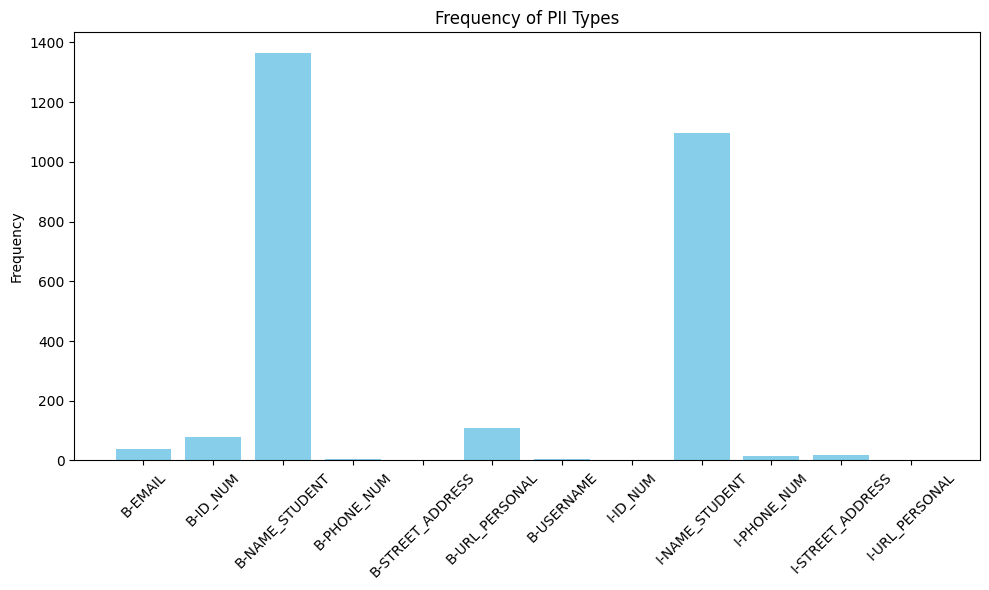

In [2]:
import numpy as np
import matplotlib.pyplot as plt

# Get unique labels and their frequencies
all_labels = np.array([x for label in df['labels'] for x in label if x != "O"])
unique_labels, label_counts = np.unique(all_labels, return_counts=True)

# Plot them
plt.figure(figsize=(10, 6))  
plt.bar(unique_labels, label_counts, color='skyblue')
plt.ylabel('Frequency')
plt.title('Frequency of PII Types')
plt.xticks(rotation=45)  
plt.tight_layout()  
plt.show()

Here we see that by far the student's name is the most common PII in our dataset, i.e. the dataset has a significant class imbalance. 

It may seem desirable to drop the classes that only contain a single example, however, in the deep learning setting the percentage of each category will be part of what the model learns and so I choose to leave them as they are. (Consider: if the training data were perfectly balanced the model would learn to predict the classes roughly equally and then this expectation would obviously not fit the real-world distribution).

Let's also quickly look at the exact counts:

In [3]:
for unique_label, label_count in zip(unique_labels, label_counts):
    print(f"{unique_label}: {label_count}")

B-EMAIL: 39
B-ID_NUM: 78
B-NAME_STUDENT: 1365
B-PHONE_NUM: 6
B-STREET_ADDRESS: 2
B-URL_PERSONAL: 110
B-USERNAME: 6
I-ID_NUM: 1
I-NAME_STUDENT: 1096
I-PHONE_NUM: 15
I-STREET_ADDRESS: 20
I-URL_PERSONAL: 1


Note the `B-` and `I-` prefixes on the labels; `B-` indicates that the span is the begining of PII, while `I-` indicates that it is a later portion of PII. While not present in this dataset, in token-classification tasks like this one it is also common for there to be a designation for the last token, such as `E-`, and occasionally one specific to single tokens, `S-`.

## 2.2 Word Counts

In this section I inspect the word counts of our essays. This can be useful as language models have varying maximum sequence lengths which may require further processing including truncation.

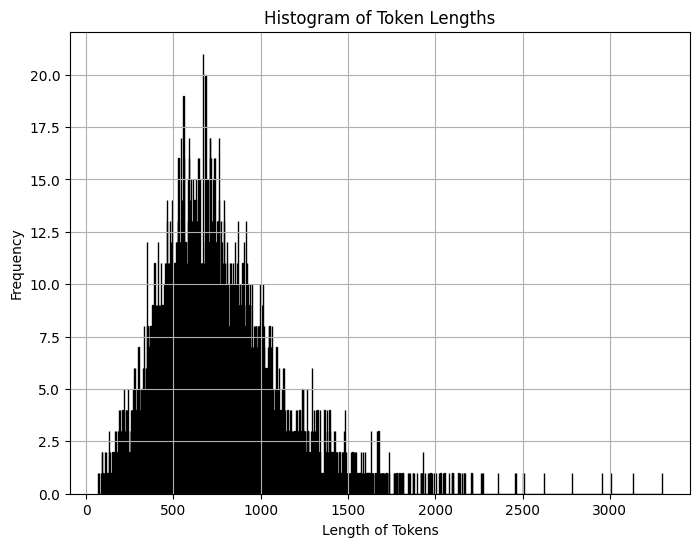

In [13]:
token_lengths = df['tokens'].apply(len)


plt.figure(figsize=(8, 6))
plt.hist(token_lengths, bins=range(min(token_lengths), max(token_lengths) + 1), color='skyblue', edgecolor='black')
plt.title('Histogram of Token Lengths')
plt.xlabel('Length of Tokens')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

In [17]:
class CFG:
    seed = 42
    preset = "lakshyakh93/deberta_finetuned_pii"
    train_seq_len = 512 
    train_batch_size = 8 
    infer_seq_len = 512 
    infer_batch_size = 2 
    epochs = 6 # number of epochs to train
    lr_mode = "exp" # lr scheduler mode from one of "cos", "step", "exp"
    
    labels = ["B-EMAIL", "B-ID_NUM", "B-NAME_STUDENT", "B-PHONE_NUM",
              "B-STREET_ADDRESS", "B-URL_PERSONAL", "B-USERNAME",
              "I-ID_NUM", "I-NAME_STUDENT", "I-PHONE_NUM",
              "I-STREET_ADDRESS","I-URL_PERSONAL","O"]
    
    id2label = dict(enumerate(labels)) 
    label2id = {v:k for k,v in id2label.items()} 
    num_labels = len(labels) 
    
    train = True 

## 2.3 Data Preprocessing

In order to be able to pass the data into our model we have to convert it into numerical tokens.

The tokens referred to above are really just words, and aren't the same tokens we will end up using. However, this creates a bit of difficulty in that our labels line up with words, when our final tokens may be chunks of words and line up incorrectly as a result.

I resolve this by duplicating the labels in cases in which a single word is split into multiple tokens.

In addition to these tokens, we add special tokens which the BERT models were pretrained with: `[CLS]` to mark the beginning of the sequence, `[SEP]` to mark the end of the sequence, and `[PAD]` tokens to add to the end so that all of our inputs have the same length even if the original essays varied.

In [9]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained(CFG.preset)

tokenizer_config.json:   0%|          | 0.00/1.31k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/798k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.11M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/78.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/173 [00:00<?, ?B/s]

In [11]:
from tqdm import tqdm

# Convert individual words into tokens

X = np.zeros((len(df), CFG.train_seq_len), int)
y = np.zeros((len(df), CFG.train_seq_len), int)

for i, (tokens, labels) in tqdm(enumerate(zip(df['tokens'], df['labels']))):
    
    # [CLS] token
    input_ids = [tokenizer.bos_token_id]
    
    # 'O' label
    input_labels = [12]
    
    for j, word in enumerate(tokens):
        ids = tokenizer(word, add_special_tokens=False)['input_ids']
       
        input_ids.extend(ids)
        
        input_labels.extend([CFG.label2id[labels[j]]] * len(ids))
        
    
    input_ids.append(tokenizer.eos_token_id)
    input_labels.append(12)
    
    
    # Padding to max length
    input_ids.extend([tokenizer.pad_token_id] * (CFG.train_seq_len - len(input_ids)))
    input_labels.extend([12] * (CFG.train_seq_len - len(input_labels)))
    
    # Truncating
    if len(input_ids) > CFG.train_seq_len:
        input_ids = input_ids[:CFG.train_seq_len]
        input_labels = input_labels[:CFG.train_seq_len]
    
        
    X[i] = input_ids
    y[i] = input_labels

6807it [04:34, 24.83it/s]


Here I additionally split the data into a train/validation split.

In [20]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [22]:
# Creating attention masks so we can ignore pad tokens

train_attention_masks = np.zeros((len(X_train), 512))

train_attention_masks[X_train != 0] = 1

val_attention_masks = np.zeros((len(X_val), 512))

val_attention_masks[X_val != 0] = 1

In [25]:
import json
from datasets import Dataset

train_ds = Dataset.from_dict({
    "input_ids": X_train,
    "attention_mask": train_attention_masks,
    "labels": y_train,
})

val_ds = Dataset.from_dict({
    "input_ids": X_val,
    "attention_mask": val_attention_masks,
    "labels": y_val,
})

print("Training set size:", len(train_ds))
print("Validation set size:", len(val_ds))

Training set size: 5445
Validation set size: 1362


# 3. Modeling

## 3.1 Architecture

For the PII detection task I choose to work off a variant of the BERT architecture which is a type of Transformer language model.

As this isn't an NLP specific deep learning course, I explain these here:

### 3.1.1 Transformers

The Transformer architecture, introduced by Vaswami et al., (2017), is a deep learning architecture widely used in Natural Language Processing but also occasionally in other areas like Computer Vision.

Transformers don't make use of recurrence for sequential data as RNNs do, which is somewhat surprising because written text can be thought of as a sequence of words. Instead, Transformers are built on top of the Attention Mechanism, which intends to mimick biological attention (paying attention to important information and ignoring the rest) which allows individual input words to be considered contextually.

In other words, this allows the model to consider a word like "Apple" differently depending on if it appears in a sentence talking about different types of fruit, or perhaps about mobile phones and laptops.

### 3.1.2 BERT

BERT is a special kind of Transformer, introduced by Devlin et al., (2018). BERT is widely used, especially for classification tasks such as PII classification, and is also relatively small compared to more recent models, allowing it to be loaded and trained on consumer hardware.

<div align="center">
    <img src="https://www.researchgate.net/publication/353380610/figure/fig2/AS:1048337872596993@1626954634319/Illustration-of-our-BERT-based-token-classification-model-Sub-tokens-with-as-prefix.png" alt="BERT for token classification.">
</div>
<center>
Figure 2: A BERT setup for token classification in the medical domain (Wang et al., 2021).
</center>

### 3.1.3 DeBERTa

The specific variant of the BERT architecture I chose to work off of is DeBERTa (He et al., 2020). DeBERTa improves BERT's performance in a wide range of tasks including token classification tasks like this one by disentangling content and position in the attention vectors (BERT uses one vector to represent both, while DeBERTa separates them into two separate vectors).

## 3.2 Training

### 3.2.1 Evaluation

For my loss function I use standard Cross Entropy Loss, however I also report a micro F-score as a more intuitive metric to judge the model on.
$ $
Specifically, $F_{\beta}$ is a weighted F-score (the mean of precision and recall). Holmes et al. (2024) recommend the usage of $\beta = 5$ meaning that recall is weighted 5 times as heavily as precision. 

In essence, the consequences of this are that we are placing more of an emphasis on catching all of the PII and not worrying as much if we get some false positives.

In [73]:
def pii_fbeta_score(pred, labels, beta=5, negative_id=12):
    """
    Parameters:
    - pred_output (dict): Model output dictionary containing predicted PII labels.
    - gt_output (dict): Ground truth output dictionary containing ground truth PII labels.
    - beta (float): The beta parameter for the F-beta score, controlling the trade-off between precision and recall.

    Returns:
    - float: Micro F-beta score.
    """   
    pred = np.argmax(pred, axis=2) # Get the predicted category from logits

    
    cm = {"TP": 0, "FP": 0, "FN": 0}
    
    TP = np.sum(np.logical_and(pred != negative_id, labels != negative_id))
    FN = np.sum(np.logical_and(pred == negative_id, labels != negative_id))
    FP = np.sum(np.logical_and(pred != negative_id, labels == negative_id))
    
    s_micro = (1 + beta**2) * TP / ((1 + beta**2) * TP + beta**2 * FN + FP)
    
    s = (1+(beta**2))*TP/(((1+(beta**2))*TP) + ((beta**2)*FN) + FP)

    return s_micro


def compute_metrics(pred):
    
    micro_fscore = pii_fbeta_score(pred.predictions, pred.label_ids)
    
    return {
        'micro_fscore': micro_fscore,
    }

## 3.2.2 Hyperparameter Tuning
After a few initial tests, I ended up decreasing the learning rate to 1e-6, which is very small, as we are fine-tuning a pretrained model and so the weights only need to be adjusted very slightly.

Additionally, I set the number of epochs to 100, but implement early stopping when validation loss doesn't decrease for 3 epochs in a row. I expect convergence long before we get to 100 epochs.

In [74]:
import torch
from transformers import Trainer, TrainingArguments, AutoModelForTokenClassification, EarlyStoppingCallback, DebertaConfig, DebertaForTokenClassification
from datasets import Dataset


training_args = TrainingArguments(
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=100,  
    #evaluation_strategy="steps",
    #eval_steps=1,
    evaluation_strategy="epoch",
    logging_dir="./logs",
    logging_steps=10,
    save_strategy="epoch",  
    save_total_limit=1,
    learning_rate=1e-6,  
    load_best_model_at_end=True,  
    metric_for_best_model='eval_loss',
    output_dir='/kaggle/working/',
)

model = AutoModelForTokenClassification.from_pretrained("lakshyakh93/deberta_finetuned_pii",
                                                        num_labels=13,
                                                        id2label=CFG.id2label,
                                                        label2id=CFG.label2id,
                                                        ignore_mismatched_sizes=True)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    compute_metrics=compute_metrics,
    callbacks = [EarlyStoppingCallback(early_stopping_patience=3)]
)

Some weights of DebertaForTokenClassification were not initialized from the model checkpoint at lakshyakh93/deberta_finetuned_pii and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([116, 768]) in the checkpoint and torch.Size([13, 768]) in the model instantiated
- classifier.bias: found shape torch.Size([116]) in the checkpoint and torch.Size([13]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [75]:
trainer.train()

Epoch,Training Loss,Validation Loss,Micro Fscore
1,0.002200,0.004739,0.372345
2,0.002100,0.002457,0.797546
3,0.000800,0.002036,0.900319
4,0.001700,0.001642,0.884431
5,0.002000,0.001557,0.868245
6,0.001200,0.001658,0.927463
7,0.000600,0.001477,0.858933
8,0.000100,0.001335,0.897236
9,0.000200,0.001796,0.936700
10,0.000500,0.001232,0.906636


TrainOutput(global_step=8853, training_loss=0.011044252659971589, metrics={'train_runtime': 6849.1239, 'train_samples_per_second': 79.499, 'train_steps_per_second': 9.943, 'total_flos': 2.157592535594496e+16, 'train_loss': 0.011044252659971589, 'epoch': 13.0})

# 4. Results

## 4.1 Training Results

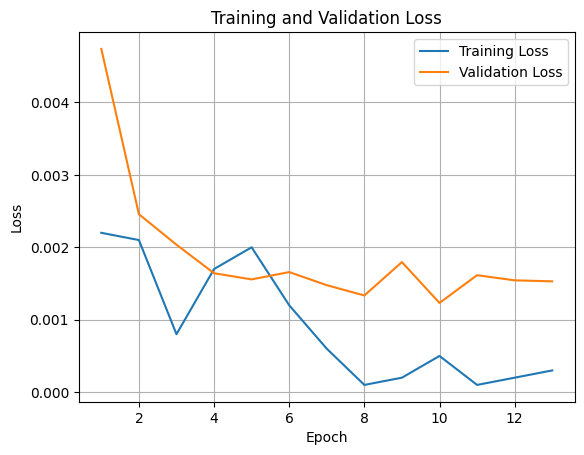

In [76]:
import matplotlib.pyplot as plt

epochs = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]
training_loss = [0.0022, 0.0021, 0.0008, 0.0017, 0.002, 0.0012, 0.0006, 0.0001, 0.000200, 0.000500, 0.000100, 0.000200, 0.000300]
validation_loss = [0.004739, 0.002457, 0.002036, 0.001642, 0.001557, 0.001658, 0.001477, 0.001335, 0.001796, 0.001232, 0.001615, 0.001544, 0.001530]

plt.plot(epochs, training_loss, label='Training Loss')
plt.plot(epochs, validation_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

We see that the validation loss decreases rather quickly and then levels off after around 10 epochs, in the future this convergence could be optimized by using an even smaller learning rate, however, as-is, the training took ~2 hours on a P100 GPU, so for the purposes of this assignment this should suffice.

## 4.2 Validation Results

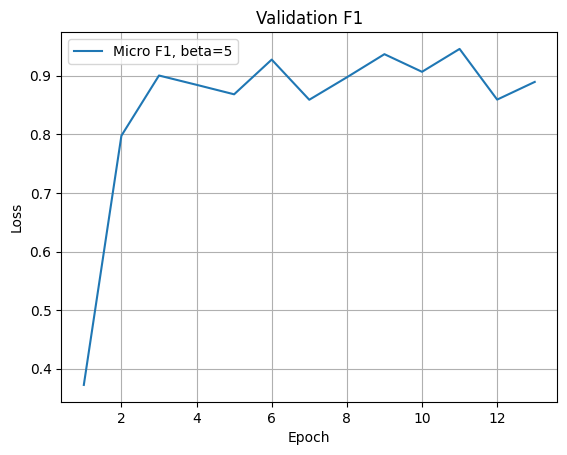

In [1]:
micro_f1 = [0.372345, 0.797546, 0.900319, 0.884431, 0.868245, 0.927463, 0.858933, 0.897236, 0.936700, 0.906636, 0.945677, 0.859198, 0.889374]
plt.plot(epochs, micro_f1, label='Micro F1, beta=5')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Validation F1')
plt.legend()
plt.grid(True)
plt.show()

Using the micro F1 score with $\beta = 5$ as described in section 3.2.1, we achieve a validation $F_5$ of ~.95. To put this in perspective, and $F_5$ of 1.0 would signify a perfect model, indicating that our training worked well.

# 5. Conclusion

In conclusion, in this assignment we fine-tuned DeBERTa, a variant of the BERT Transformer language model, on our specific token classification task: PII detection.

We achieve a validation $F_5$ of ~.95, making our approach competitive with current leaderboard results that max out at $F_5 = .977$, although these make use of ensembles of models making our approach significantly more computationally efficient.

## 5.1 Future Work

In order to improve the model's performance even further, logical next steps include:
1. Decrease the learning rate even further beyond 1e-6, potentially to 1e-7 or lower, and allow for longer training times.
2. Implement an ensemble of models (i.e. training multiple different architectures in the same way I have) and a voting scheme.
3. Directly use $F_5$ as the loss metric. In this assignment I use standard cross entropy loss which doesn't necessarily maximize $F_5$.

# References

Devlin, J., Chang, M. W., Lee, K., & Toutanova, K. (2018). Bert: Pre-training of deep bidirectional transformers for language understanding. arXiv preprint arXiv:1810.04805.

He, P., Liu, X., Gao, J., & Chen, W. (2020). Deberta: Decoding-enhanced bert with disentangled attention. arXiv preprint arXiv:2006.03654.

Holmes, L., Crossley, S., Baffour, P., King, J., Burleigh, L., Demkin, M., Holbrook, R., Reade, W., & Howard, A. (2024). The Learning Agency Lab - PII Data Detection. Kaggle. https://kaggle.com/competitions/pii-detection-removal-from-educational-data

Vaswani, A., Shazeer, N., Parmar, N., Uszkoreit, J., Jones, L., Gomez, A. N., ... & Polosukhin, I. (2017). Attention is all you need. Advances in neural information processing systems, 30.

Wang, H., Yeung, W. L. K., Ng, Q. X., Tung, A., Tay, J. A. M., Ryanputra, D., ... & Arulanandam, S. (2021). A weakly-supervised named entity recognition machine learning approach for emergency medical services clinical audit. International journal of environmental research and public health, 18(15), 7776.